Final project.

    Write a python module to periodically scan and parse news from newswire website. (20 Marks)
    https://www.prnewswire.com/news-releases/news-releases-list/
    Keep track of the already parsed news:  (20 Marks)
    For all unparsed news, scan the content of the news to find a stock symbol.
    e.g. (TSX:SHOP)
    Scan the yahoo finance for the stock symbol appeared in the news. (30 Marks)
    - Get the stock price and volume of last 5 days.
    Prepare a nice visualization showing the News headline and Stock prices of last 5 days. (30 Marks)

- Visualization should be a plot (time - series) for Volume and Daily Close Price

In [2]:
import pandas as pd
import numpy as np 

import matplotlib.pyplot as plt 
import matplotlib.gridspec as gridspec
import seaborn as sns

from lxml.html import parse
from pandas.io.parsers import TextParser
from urllib.request import urlopen, Request
import threading
import time
from threading import Timer            
import requests
from bs4 import BeautifulSoup
import plotly.graph_objects as go

In [3]:
#Add User-Agent to slove http error 403
def _geturl(url):
    headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/86.0.4240.198 Safari/537.36",
        }
    return urlopen(Request(url, headers=headers))

def openwebset(url):
    page = _geturl(url)
    parsed = parse(page)
    return parsed.getroot()

Parse html data

In [4]:
def _unpack(row, kind='td'):
    elts = row.findall('.//%s' % kind)
    return [val.text_content() for val in elts]

def parser_option_data(table, num=5):
    rows = table.findall('.//tr')
    if( rows):
        header = _unpack(rows[0],'th')
        # only keep top {num} rows
        data= [_unpack(r) for r in rows[1:num+1]]
    return TextParser(data, names=header).get_chunk()

Get all news from webset

In [5]:
def getnews(url = 'https://www.prnewswire.com/news-releases/news-releases-list/'):
    page = _geturl(url)
    parsed = parse(page)
    doc = parsed.getroot()
    newslist = []
    for lnk in doc.findall(".//div[@class='card']"):
        news = {
            'thumbnail': lnk.find(".//img").get('src'),
            'time_short':     lnk.find(".//small").text_content(),
            'link':     'https://www.prnewswire.com' + lnk.find(".//a").get('href'),
            'title':    lnk.find(".//a[@title]").text_content(),
            'abstract': lnk.find(".//p").text_content(),
        }
        # get news content
        content_doc = parse(_geturl(news['link'])).getroot()
        news['time'] = content_doc.find(".//p[@class='mb-no']").text_content()
        #news['content'] = content_doc.xpath(".//section[contains(@class, 'release-body')]")[0].text_content()
        newslist.append(news)
    return pd.DataFrame(newslist)

Filter new news

In [6]:
def filternews(df_old = pd.DataFrame()):
    df_new = getnews()
    if len(df_old) > 0:
        df_new = df_new[~df_new['link'].isin(df_old['link'])]
    for index, row in df_new.iterrows():
        print(f"\n\n{row['time']}:\n{row['title']}\n{row['link']}")
        #showpic(row['thumbnail'])
        filterstockcode(row['link'])
        
    return df_old.append(df_new, ignore_index=True)

In [7]:
def updatenews(data):
    display(data)

Display Picture

In [8]:
def showpic(url):
    im_data = plt.imread( _geturl(url), 0)
    height = 0
    width = 0
    depth = 0
    
    try:
        height, width, depth = im_data.shape
    except:
        ;
    dpi = 72
    # What size does the figure need to be in inches to fit the image?
    figsize = width / float(dpi), height / float(dpi)

    # Create a figure of the right size with one axes that takes up the full figure
    fig = plt.figure(figsize=figsize)
    ax = fig.add_axes([0, 0, 1, 1])
    # Hide spines, ticks, etc.
    ax.axis('off')
    # Display the image.
    im = ax.imshow(im_data, cmap='gray')
    plt.show()

Get stock code in news content

In [9]:
def filterstockcode(url):
    page = _geturl(url)
    soup = BeautifulSoup(page, 'html.parser')
    symbols = soup.find_all(class_="ticket-symbol")
    codes = []
    for symbol in symbols:
        if( symbol):
            ticket_code = symbol.string
            
            if( ticket_code in codes):
                ;
            else:
                codes.append(ticket_code) 

    for code in codes:
        df = getstockdata(code)
        CandleStickChart(df, code)

Get stock histroy data

In [10]:
def getstockdata(stocksymbol, num=5):
    url = f'https://finance.yahoo.com/quote/{stocksymbol}/history'
    doc = openwebset(url)
    tables = doc.findall('.//table')
    if(tables):
        df = parser_option_data(tables[0]) 
        # symbol is not in yahoo finance db, log and return
        if 'Date' not in df.columns:
            print(f"Can not retreive quote for symbol {stocksymbol} by url {url}")
            return pd.DataFrame()
    
        # data format convert
        for col in df.columns:
            if col=='Date':
                df['Date'] = pd.to_datetime(df['Date'], format='%b %d, %Y')
            elif df[col].dtype != np.float64:
                try:
                    df[col] = df[col].str.replace(',','').astype(float)
                except:
                    ;        
        return df.sort_values('Date').reset_index(drop=True)


Plot the stock price and volume

In [11]:
def CandleStickChart(df, code):
    if( len(df)>0):
        print(f'Stock Symbol: {code}')
        
        display(df)
        
        fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5))
        
        ax1 = sns.lineplot(x=df['Date'], y=df['Open'], marker='o', ax=ax1)
        ax1 = sns.lineplot(x=df['Date'], y=df['High'], marker='o', ax=ax1)
        ax1 = sns.lineplot(x=df['Date'], y=df['Low'], marker='o', ax=ax1)
        ax1 = sns.lineplot(x=df['Date'], y=df['Close*'], marker='o', ax=ax1)
        ax1.set_ylabel('Close')
        ax1.legend(['Open','High','Low','Close'])
        sns.lineplot(x='Date', y='Volume', data = df, marker='o', ax=ax2)
        plt.show()

Main Function



Dec 11, 2020, 15:00 ET:
Insights on the Organ Preservation Global Market to 2025 - Key Driving Factors and Challenges
https://www.prnewswire.com/news-releases/insights-on-the-organ-preservation-global-market-to-2025---key-driving-factors-and-challenges-301191185.html


Dec 11, 2020, 15:00 ET:
¡Vea lo último en tendencias de automóviles aquí! El nuevo show de autos
https://www.prnewswire.com/news-releases/-vea-lo-ultimo-en-tendencias-de-automoviles-aqui-el-nuevo-show-de-autos-838315781.html


Dec 11, 2020, 14:54 ET:
Dominion Energy's Board of Directors Sets 2021 Dividend Rate
https://www.prnewswire.com/news-releases/dominion-energys-board-of-directors-sets-2021-dividend-rate-301191441.html
Stock Symbol: D


,Date,Open,High,Low,Close*,Adj Close**,Volume
0,2020-12-07,75.68,76.36,75.35,76.14,76.14,6291000.0
1,2020-12-08,75.62,75.80,74.59,74.75,74.75,8752100.0
2,2020-12-09,74.61,74.84,73.16,74.30,74.30,8010900.0
3,2020-12-10,75.01,75.30,73.96,74.32,74.32,6424300.0
4,2020-12-11,73.91,74.92,73.94,74.66,74.66,2324701.0


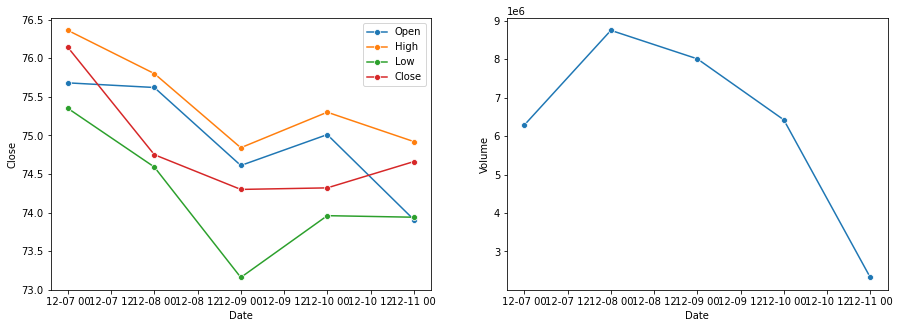

Can not retreive quote for symbol None by url https://finance.yahoo.com/quote/None/history


Dec 11, 2020, 14:51 ET:
LOOKING FOR YOUR AUTO SHOW FIX? SEE THE LATEST IN AUTOMOTIVE TRENDS HERE!
https://www.prnewswire.com/news-releases/looking-for-your-auto-show-fix-see-the-latest-in-automotive-trends-here--834569255.html


Dec 11, 2020, 14:45 ET:
Worldwide Feminine Hygiene Products Industry to 2025 - Players Include Kao, Daio Paper & Ontex
https://www.prnewswire.com/news-releases/worldwide-feminine-hygiene-products-industry-to-2025---players-include-kao-daio-paper--ontex-301191361.html


Dec 11, 2020, 14:39 ET:
EY announces the EY Microsoft Services Group designed to propel companies' digital transformations and help deliver long-term value
https://www.prnewswire.com/news-releases/ey-announces-the-ey-microsoft-services-group-designed-to-propel-companies-digital-transformations-and-help-deliver-long-term-value-301191434.html


Dec 11, 2020, 14:32 ET:
News Leaders Call On China To Release B

,Date,Open,High,Low,Close*,Adj Close**,Volume
0,2020-12-07,147.30,148.33,146.48,147.42,147.42,2637200.0
1,2020-12-08,146.98,150.14,146.91,149.30,149.30,2754400.0
2,2020-12-09,154.59,158.94,153.68,158.00,158.00,8364400.0
3,2020-12-10,159.87,162.00,158.18,161.00,161.00,6429800.0
4,2020-12-11,159.72,161.15,159.11,160.40,160.40,2064718.0


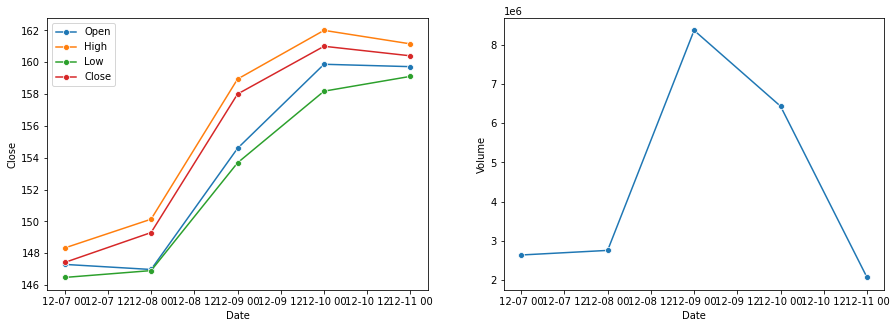

Stock Symbol: INCY


,Date,Open,High,Low,Close*,Adj Close**,Volume
0,2020-12-07,83.44,83.95,82.22,83.06,83.06,744500.0
1,2020-12-08,83.20,83.20,82.09,82.85,82.85,697200.0
2,2020-12-09,82.79,82.79,80.62,80.96,80.96,946000.0
3,2020-12-10,81.22,82.39,80.82,82.05,82.05,918900.0
4,2020-12-11,81.76,82.21,80.79,81.49,81.49,433869.0


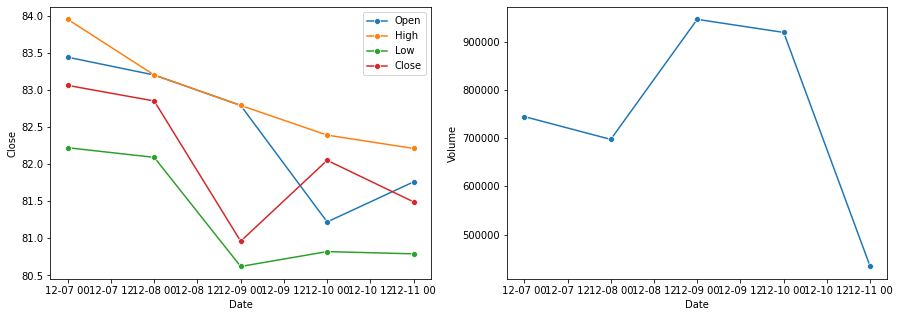



Dec 11, 2020, 14:00 ET:
Church's Chicken® Taps Mitch Langston As New VP Of Franchise Development For U.S. Operations
https://www.prnewswire.com/news-releases/churchs-chicken-taps-mitch-langston-as-new-vp-of-franchise-development-for-us-operations-301191366.html


Dec 11, 2020, 14:00 ET:
European C5ISR Systems Industry to 2030 - Impact of COVID-19 on the Market
https://www.prnewswire.com/news-releases/european-c5isr-systems-industry-to-2030---impact-of-covid-19-on-the-market-301191358.html
Check news at Fri Dec 11 15:08:51 2020
Check news at Fri Dec 11 15:09:04 2020
Check news at Fri Dec 11 15:09:16 2020
Check news at Fri Dec 11 15:09:29 2020
Check news at Fri Dec 11 15:09:40 2020
Check news at Fri Dec 11 15:09:52 2020
Check news at Fri Dec 11 15:10:03 2020
Check news at Fri Dec 11 15:10:16 2020
Check news at Fri Dec 11 15:10:28 2020
Check news at Fri Dec 11 15:10:39 2020
Check news at Fri Dec 11 15:10:51 2020
Check news at Fri Dec 11 15:11:02 2020
Check news at Fri Dec 11 15:11:14 20

Check news at Fri Dec 11 15:36:14 2020
Check news at Fri Dec 11 15:36:25 2020
Check news at Fri Dec 11 15:36:35 2020
Check news at Fri Dec 11 15:36:47 2020
Check news at Fri Dec 11 15:36:58 2020
Check news at Fri Dec 11 15:37:08 2020
Check news at Fri Dec 11 15:37:18 2020
Check news at Fri Dec 11 15:37:29 2020
Check news at Fri Dec 11 15:37:40 2020
Check news at Fri Dec 11 15:37:54 2020
Check news at Fri Dec 11 15:38:07 2020
Check news at Fri Dec 11 15:38:17 2020


Dec 11, 2020, 15:36 ET:
La solution SmartVista de BPC émerge comme leader dans la SPARK Matrix de Quadrant 2020 pour la gestion de cartes bancaires
https://www.prnewswire.com/news-releases/la-solution-smartvista-de-bpc-emerge-comme-leader-dans-la-spark-matrix-de-quadrant-2020-pour-la-gestion-de-cartes-bancaires-891205886.html
Check news at Fri Dec 11 15:38:30 2020
Check news at Fri Dec 11 15:38:41 2020
Check news at Fri Dec 11 15:38:52 2020
Check news at Fri Dec 11 15:39:02 2020
Check news at Fri Dec 11 15:39:13 2020
Check n

KeyboardInterrupt: 

In [13]:
if __name__ == "__main__":
    import time
    interval = 2
    df = filternews()
    
    while True:
        time.sleep( interval )
        print(f'Check news at {time.ctime()}')
        df = filternews(df)

Unit Test

Stock Symbol: ACRX


,Date,Open,High,Low,Close*,Adj Close**,Volume
0,2020-12-03,1.46,1.47,1.42,1.4300,1.4300,849000.0
1,2020-12-04,1.45,1.55,1.42,1.5200,1.5200,1182500.0
2,2020-12-07,1.51,1.55,1.46,1.4600,1.4600,823700.0
3,2020-12-08,1.47,1.47,1.40,1.4500,1.4500,1491300.0
4,2020-12-09,1.42,1.46,1.41,1.4184,1.4184,445325.0


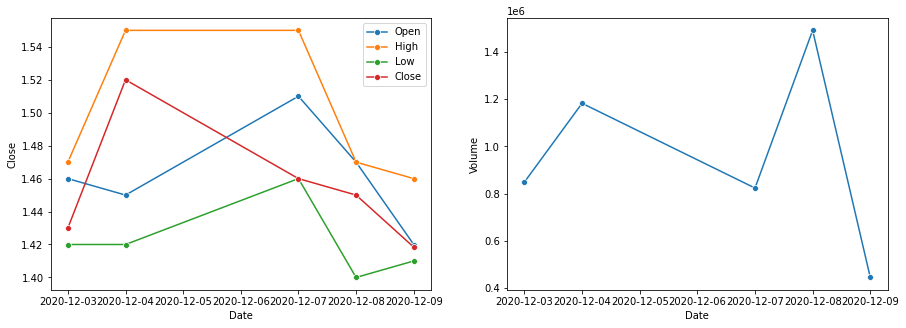

In [42]:
#get stockcode from news content
url = 'https://www.prnewswire.com/news-releases/acelrx-pharmaceuticals-to-present-at-ld-micro-main-event-301189692.html'
filterstockcode(url)

Stock Symbol: ACRX


,Date,Open,High,Low,Close*,Adj Close**,Volume
0,2020-12-03,1.46,1.47,1.42,1.430,1.430,849000.0
1,2020-12-04,1.45,1.55,1.42,1.520,1.520,1182500.0
2,2020-12-07,1.51,1.55,1.46,1.460,1.460,823700.0
3,2020-12-08,1.47,1.47,1.40,1.450,1.450,1491300.0
4,2020-12-09,1.42,1.46,1.41,1.415,1.415,448625.0


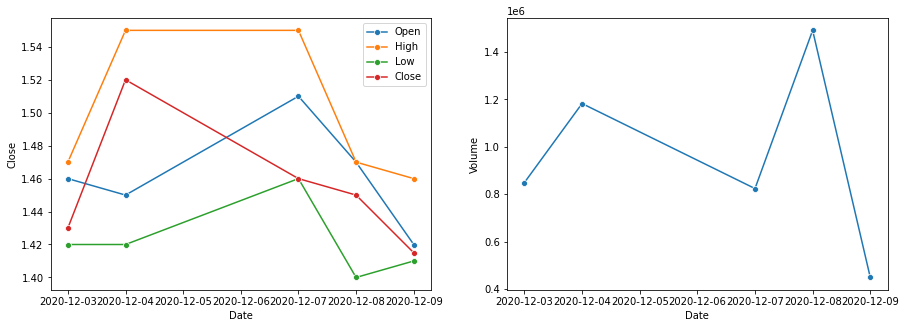

In [44]:
#test Stock Symbol: ACRX
stocksymbol = 'ACRX' 
df = getstockdata(stocksymbol)
CandleStickChart(df,stocksymbol )